In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import psycopg2
import pandas as pd
import psycopg2.extras
import seaborn as sns
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="ecomdb",
                                           user = "postgres",
                                           password = "hai",
                                           host = "127.0.0.1",
                                           port = "5432")

    def getConnection(self):
        print("successfully connected to database")
        return self.connection

In [6]:
con = PostgresConnection().getConnection()

successfully connected to database


# Q1: Find the division wise total_sale_price from 2018 to 2019 joining fact table and respective dimension table

In [18]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT s.division, SUM(t.sales_price) " \
              "FROM star_schema.fact_sales t " \
              "JOIN star_schema.dim_geography s on s.geo_key=t.geo_key " \
                "JOIN star_schema.dim_time tim on tim.time_key=t.time_key " \
                "WHERE tim.year>=2018 and tim.year<=2019 " \
                "GROUP BY CUBE(s.division) " \
                "ORDER BY s.division "
cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [19]:
records

[('BARISAL', Decimal('2631900')),
 ('CHITTAGONG', Decimal('7704270')),
 ('DHAKA', Decimal('44940300')),
 ('KHULNA', Decimal('3868700')),
 ('RAJSHAHI', Decimal('4527270')),
 ('RANGPUR', Decimal('3697820')),
 ('SYLHET', Decimal('2697110')),
 (None, Decimal('70067370'))]

In [20]:
df_q1 = pd.DataFrame(records, columns=['division', 'sales'])
df_q1

,division,sales
0,BARISAL,2631900
1,CHITTAGONG,7704270
2,DHAKA,44940300
3,KHULNA,3868700
4,RAJSHAHI,4527270
5,RANGPUR,3697820
6,SYLHET,2697110
7,None,70067370


In [21]:
#we need to remove the total row 
df_q1 =df_q1.dropna()

In [22]:
df_q1

,division,sales
0,BARISAL,2631900
1,CHITTAGONG,7704270
2,DHAKA,44940300
3,KHULNA,3868700
4,RAJSHAHI,4527270
5,RANGPUR,3697820
6,SYLHET,2697110


In [23]:
#The sales are stored as string. So we need to typecast them. 
def changetype(x):
    x['sales']=x['sales'].astype('float64')  

In [24]:
#We will change all value of the df_q1 list
changetype(df_q1)

C:\Users\USER\AppData\Local\Temp\ipykernel_15516\3423188846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sales']=x['sales'].astype('float64')


In [25]:
df_q1

,division,sales
0,BARISAL,2631900.0
1,CHITTAGONG,7704270.0
2,DHAKA,44940300.0
3,KHULNA,3868700.0
4,RAJSHAHI,4527270.0
5,RANGPUR,3697820.0
6,SYLHET,2697110.0


In [26]:
#This is not mandatory. But if we won't use then label 0 1 2 ... will show instead of divisoin name
#So we need to set index as not 0, 1, 2 but division name 
df_q1=df_q1.set_index(['division'])
df_q1

,sales
division,
BARISAL,2631900.0
CHITTAGONG,7704270.0
DHAKA,44940300.0
KHULNA,3868700.0
RAJSHAHI,4527270.0
RANGPUR,3697820.0
SYLHET,2697110.0


<Axes: ylabel='sales'>

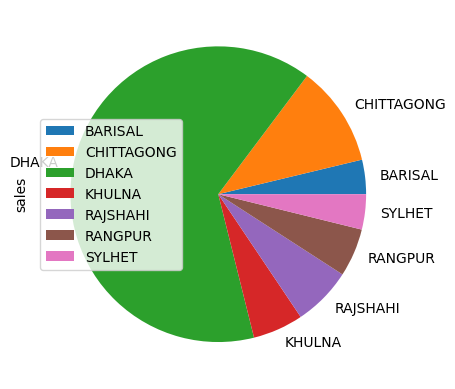

In [27]:
df_q1.plot.pie(y='sales')

<Axes: xlabel='division'>

<Figure size 1000x500 with 0 Axes>

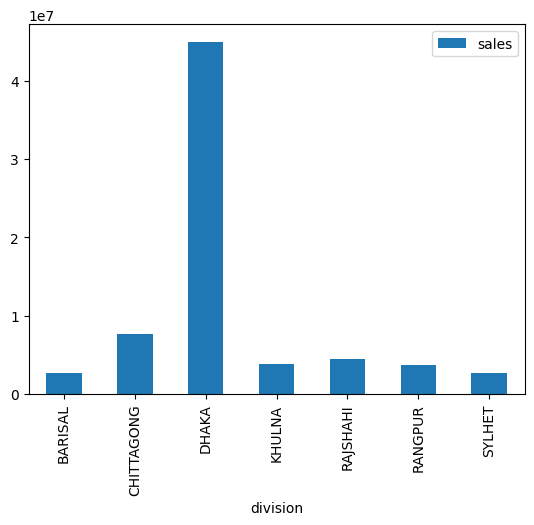

In [28]:
plt.figure(figsize=(10,5))
df_q1.plot.bar(y='sales')

# Q2: Find the hospital name along with it's branch name with most sales_price in 2019

In [46]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT s.hospital_name, s.branch_name, SUM(t.sales_price) " \
              "FROM star_schema.fact_sales t " \
              "JOIN star_schema.dim_hospital s on s.hospital_key=t.hospital_key " \
                "JOIN star_schema.dim_time tim on tim.time_key=t.time_key " \
                "WHERE tim.year=2019 " \
            "GROUP BY CUBE(s.hospital_name, s.branch_name) " \
                "ORDER BY SUM(t.sales_price)"
cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [47]:
records

[(None, None, Decimal('63360130')),
 ('BANGLADESH EYE HOSPITAL LTD.', 'Dhanmondi', Decimal('63360130')),
 ('BANGLADESH EYE HOSPITAL LTD.', None, Decimal('63360130')),
 (None, 'Dhanmondi', Decimal('63360130'))]

In [48]:
host= pd.DataFrame(list(records), columns=['hospital_name', 'branch_name', 'sales'])
host=host.dropna()
host=host.head(1)
changetype(host)
host.dtypes

hospital_name     object
branch_name       object
sales            float64
dtype: object

In [49]:
host

,hospital_name,branch_name,sales
1,BANGLADESH EYE HOSPITAL LTD.,Dhanmondi,63360130.0


# Q3: Find the test name which has increased in 2020 from 2019

In [67]:
con = PostgresConnection().getConnection()
cur = con.cursor()

select_stmt = "SELECT tt.test_name " \
              "FROM star_schema.fact_sales ft " \
              "JOIN star_schema.dim_test tt on ft.test_key = tt.test_key " \
                "JOIN star_schema.dim_time t1 ON ft.time_key = t1.time_key " \
                "JOIN star_schema.dim_time t2 ON ft.time_key = t2.time_key " \
"WHERE t1.year = 2019 AND t2.year = 2020 "\
"GROUP BY tt.test_name "\


"HAVING SUM(CASE WHEN t1.year = 2019 THEN ft.sales_price ELSE 0 END) < "\
"SUM(CASE WHEN t2.year = 2020 THEN ft.sales_price ELSE 0 END) "
    
cur.execute(select_stmt)
records = cur.fetchall()
records
test= pd.DataFrame(list(records), columns=['test_key', 'test_name'])
test=test.dropna()
test


successfully connected to database


[]

In [71]:
#Given data is not enough. There is actually no test that was in 2019 and 2020 at the same time. 

con = PostgresConnection().getConnection()
cur = con.cursor()

select_stmt = "SELECT tt.test_name , t1.year, t2.year " \
              "FROM star_schema.fact_sales ft " \
              "JOIN star_schema.dim_test tt on ft.test_key = tt.test_key " \
                "JOIN star_schema.dim_time t1 ON ft.time_key = t1.time_key " \
                "JOIN star_schema.dim_time t2 ON ft.time_key = t2.time_key " 

cur.execute(select_stmt)
records = cur.fetchall()
records


successfully connected to database


[('APTT', 2019, 2019),
 ('Total Iron Binding Capacity (TIBC) Blood', 2019, 2019),
 ('Albumin Serum', 2019, 2019),
 ('Iron Serum', 2019, 2019),
 ('Serum creatinine level', 2019, 2019),
 ('Electrolytes Serum', 2019, 2019),
 ('Uric Acid Serum', 2019, 2019),
 ('TSH', 2019, 2019),
 ('Complete Urine Analysis (Urine R/E)', 2019, 2019),
 ('HbA1c', 2018, 2018),
 ('Electrolytes Serum', 2018, 2018),
 ('Serum IgE', 2018, 2018),
 ('CEA', 2018, 2018),
 ('HbA1c', 2019, 2019),
 ('Electrolytes Serum', 2019, 2019),
 ('Serum IgE', 2019, 2019),
 ('CEA', 2019, 2019),
 ('Ammonia Blood', 2019, 2019),
 ('Electrolytes Serum', 2019, 2019),
 ('CBC', 2019, 2019),
 ('Complete Urine Analysis (Urine R/E)', 2019, 2019),
 ('APTT', 2019, 2019),
 ('Prothrombin Time (PT)', 2019, 2019),
 ('CBC', 2019, 2019),
 ('CBC', 2019, 2019),
 ('Electrolytes Serum', 2019, 2019),
 ('CBC', 2019, 2019),
 ('Blood Grouping and Rh Factor', 2019, 2019),
 ('APTT', 2019, 2019),
 ('Prothrombin Time (PT)', 2019, 2019),
 ('Albumin Serum', 2019, 2

# Q4: Find the hospital which has most test in 2019

In [79]:
con = PostgresConnection().getConnection()
cur = con.cursor()
#month are stored as number januray is 1 november is 11 and so on
select_stmt = "SELECT hos.hospital_key, hos.hospital_name, count(tes.test_key) " \
              "FROM star_schema.fact_sales t " \
              "JOIN star_schema.dim_hospital hos on hos.hospital_key=t.hospital_key " \
                "JOIN star_schema.dim_test tes on tes.test_key=t.test_key " \
"GROUP BY CUBE(hos.hospital_key, hos.hospital_name) " \
                "ORDER BY count(tes.test_key) desc"
cur.execute(select_stmt)
records = cur.fetchall()
records


successfully connected to database


[(None, None, 92083),
 ('100001', 'BANGLADESH EYE HOSPITAL LTD.', 92083),
 ('100001', None, 92083),
 (None, 'BANGLADESH EYE HOSPITAL LTD.', 92083)]

In [80]:
hospitals= pd.DataFrame(list(records), columns=['hospital_key', 'hospital_name', 'total_test'])
hospitals
hospitals=hospitals.dropna()
hospitals

,hospital_key,hospital_name,total_test
1,100001,BANGLADESH EYE HOSPITAL LTD.,92083


In [82]:
hospitals=hospitals.head(1)
hospitals

,hospital_key,hospital_name,total_test
1,100001,BANGLADESH EYE HOSPITAL LTD.,92083


# Q5 Find the lab which has most contribution in 2019

In [83]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT l.lab_name, count(f.sales_price) " \
              "FROM star_schema.fact_sales f " \
              "JOIN star_schema.dim_lab l on l.lab_key=f.lab_key " \
                "GROUP BY CUBE(l.lab_name) " \
                "ORDER BY count(f.sales_price) desc"
cur.execute(select_stmt)
records = cur.fetchall()
records

successfully connected to database


[(None, 92083),
 ('Biochemistry', 43206),
 ('Immunology', 17664),
 ('Haematology', 16078),
 ('Clinical Pathology', 5795),
 ('Serology', 3856),
 ('Microbiology', 3812),
 ('BLOOD TRANSFUSION', 1067),
 ('HISTO-PATHOLOGY', 265),
 ('CYTO-PATHOLOGY', 208),
 ('PCR LAB', 130),
 ('PHARMACOGENETICS LAB', 2)]

In [84]:
df_lab = pd.DataFrame(records, columns=['labk_name', 'count'])
df_lab

,labk_name,count
0,None,92083
1,Biochemistry,43206
2,Immunology,17664
3,Haematology,16078
4,Clinical Pathology,5795
5,Serology,3856
6,Microbiology,3812
7,BLOOD TRANSFUSION,1067
8,HISTO-PATHOLOGY,265
9,CYTO-PATHOLOGY,208


In [87]:
#dropna() funtion is used to remove nan rows
df_lab=df_lab.dropna()
df_lab

,labk_name,count
1,Biochemistry,43206
2,Immunology,17664
3,Haematology,16078
4,Clinical Pathology,5795
5,Serology,3856
6,Microbiology,3812
7,BLOOD TRANSFUSION,1067
8,HISTO-PATHOLOGY,265
9,CYTO-PATHOLOGY,208
10,PCR LAB,130
